# Stats of Extreme Events

https://scia.isprambiente.it/

Regione Selezionata: Sicilia



In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [154]:

series = pd.read_csv("Sicilia.csv")

# parsing coerente col tuo formato (JAN-01-1952)
series["data"] = pd.to_datetime(series["data"], format="%b-%d-%Y", errors="coerce")

# numerico
series["Precipitazioni cumulate"] = pd.to_numeric(series["Precipitazioni cumulate"], errors="coerce")

# filtro periodo (per essere sicuro)
series = series[(series["data"] >= "1951-01-01") & (series["data"] <= "2022-12-31")]


In [155]:
print(type(series))
series

<class 'pandas.core.frame.DataFrame'>


,rete,anagrafica,data,Precipitazioni cumulate
0,REGIONI - ex SIMN,Milazzo,1958-02-01,0.0
1,REGIONI - ex SIMN,Milazzo,1958-02-02,0.0
2,REGIONI - ex SIMN,Milazzo,1958-02-03,0.0
3,REGIONI - ex SIMN,Milazzo,1958-02-04,0.0
4,REGIONI - ex SIMN,Milazzo,1958-02-05,0.0
...,...,...,...,...
305760,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-27,0.0
305761,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-28,0.0
305762,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-29,0.0
305763,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-30,0.0


In [156]:
# stampo il primo valore della riga ("data")
series.index[0]

np.int64(0)

In [157]:
print(len(series))

255079


In [158]:
# raggruppo i dati su ogni giorno e considero il massimo
# rimuovo le colonne rete e anagrafica
data = series.groupby(["data"]).max().drop(["rete","anagrafica"], axis=1).squeeze()
data

data
1951-01-01     2.080
1951-01-02     0.938
1951-01-03     4.632
1951-01-04    20.000
1951-01-05    10.000
               ...  
2022-12-27     0.300
2022-12-28     0.400
2022-12-29     0.300
2022-12-30     0.200
2022-12-31     0.400
Name: Precipitazioni cumulate, Length: 26298, dtype: float64

In [159]:
print(len(data))

26298


In [160]:
from pyextremes import EVA

model = EVA(data)

In [161]:
model.get_extremes(method="BM", block_size="365.2425D",errors="coerce")

In [162]:
# Restituisce i valori estremi
print(len(model.extremes))
model.extremes

72


data
1951-10-17    225.0
1952-02-06     85.0
1953-10-27    124.0
1954-12-13     95.0
1955-01-24     87.2
              ...  
2018-10-04    121.8
2019-11-12     92.2
2020-07-04     94.2
2021-10-25    153.9
2022-11-26     75.9
Name: Precipitazioni cumulate, Length: 72, dtype: float64

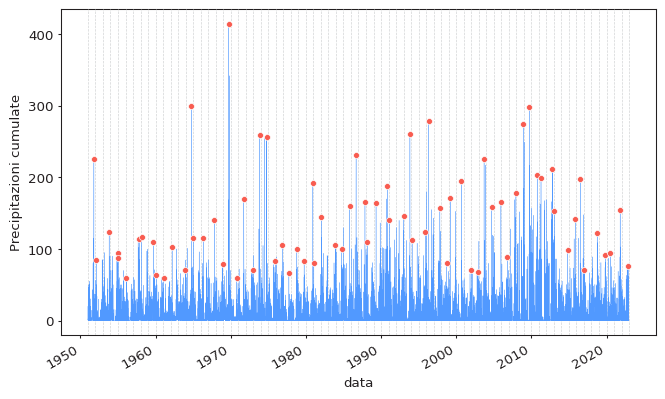

In [163]:
model.plot_extremes()
plt.show()

In [164]:
# Ordino i massimi dal più grande al più piccolo
model.extremes.sort_values(ascending=False)

data
1969-09-30    414.6
1964-09-30    300.0
2009-09-25    299.0
1996-05-10    278.9
2008-12-11    275.1
              ...  
1977-09-27     65.8
1960-02-01     63.5
1961-01-24     60.0
1970-10-17     60.0
1956-02-05     59.2
Name: Precipitazioni cumulate, Length: 72, dtype: float64

In [165]:
# Ottimizzazione della likelihood con il metodo Akaike Information Criterion (AIC)
model.fit_model()


In [166]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
summary = model.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [167]:
summary

,return value,lower ci,upper ci
return period,,,
1.0,-61.519713,NaN,59.990519
2.0,123.062193,63.452742,143.457849
5.0,186.978971,159.253719,449.051139
10.0,241.048066,205.422672,9126.703205


## Empirical Return Periods

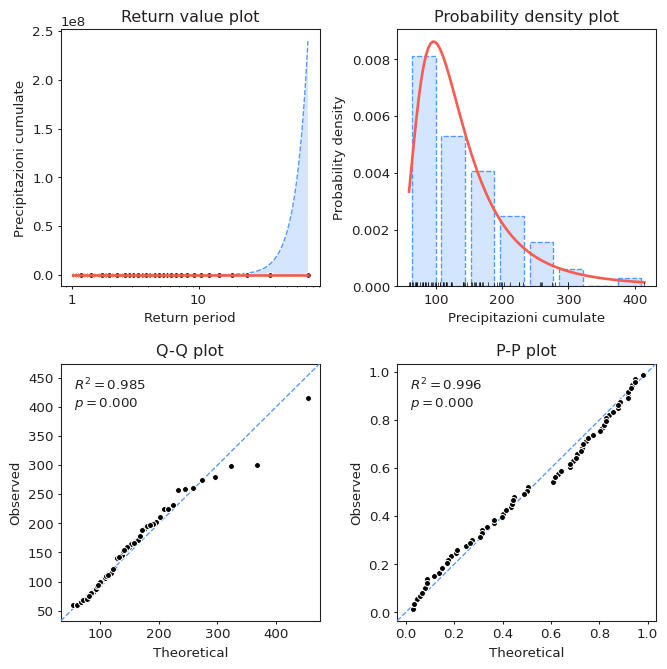

In [168]:
# Genera dei grafici sul periodo di ritorno, sulla densità di probabilità

model.plot_diagnostic(alpha=0.95)
plt.show()

In [169]:
# Distribuzione genextreme (GEV)
# parametri: c è ξ (forma, < 0 è Weibull) loc è μ (posizione), scale è σ (dispersione)
print(model.distribution)

               pyextremes distribution                
------------------------------------------------------
name: genextreme                                      
free parameters: c, loc, scale                        
fixed parameters: all parameters are free             
fitted parameters: c=-0.262, loc=106.141, scale=43.984
------------------------------------------------------


## Estimating Return Periods

In [170]:
from pyextremes import get_return_periods

return_periods = get_return_periods(
    ts=data,
    extremes=model.extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D"
)
return_periods.sort_values("return period", ascending=False).head(10)

,Precipitazioni cumulate,exceedance probability,return period
data,,,
1969-09-30,414.6,0.013699,73.000000
1964-09-30,300.0,0.027397,36.500000
2009-09-25,299.0,0.041096,24.333333
1996-05-10,278.9,0.054795,18.250000
2008-12-11,275.1,0.068493,14.600000
1993-11-04,260.1,0.082192,12.166667
1973-11-08,259.1,0.095890,10.428571
1974-10-13,257.0,0.109589,9.125000
1986-09-06,230.9,0.123288,8.111111


## Peaks Over Threshold

In [171]:
# ============================================================
# POT: scelta soglia a priori (no ottimizzazione su R²)
# ============================================================
# Razionale
# Nel POT la soglia u deve essere fissata indipendentemente dal fit del modello.
# Non va scelta massimizzando metriche di bontà (es. R² su QQ/PP), perché introdurrebbe bias.
# La letteratura EVT propone soglie alte fissate a priori o motivate tramite diagnostiche
# come mean excess (mean residual life) e stability plots.
#Fonte: Peaks-over-Threshold Study of Trends in Extreme Rainfall over the Iberian Peninsula, Acero et al. 2011
# https://doi.org/10.1175/2010JCLI3627.1

model2 = EVA(data)

q = 0.97  # puoi usare 0.95 / 0.97 / 0.99. 0.97 è un buon compromesso
threshold = float(data.quantile(q))

model2.get_extremes("POT", threshold=threshold, r="30D")
model2.fit_model(distribution="genpareto", distribution_kwargs={})

print(f"Soglia POT fissata a priori: quantile {q} = {threshold:.2f} mm")
print("Numero exceedances (declustered):", len(model2.extremes))


Soglia POT fissata a priori: quantile 0.97 = 48.60 mm
Numero exceedances (declustered): 230


In [172]:
# ============================================================
# Sensitivity analysis: robustezza rispetto alla soglia
# ============================================================

qs = [0.95, 0.97, 0.99]
rows = []

for q in qs:
    thr = float(data.quantile(q))
    m = EVA(data)
    m.get_extremes("POT", threshold=thr, r="30D")
    m.fit_model(distribution="genpareto", distribution_kwargs={})
    rows.append({
        "quantile": q,
        "threshold": thr,
        "n_extremes": len(m.extremes),
        "shape_xi": float(m.distribution.mle_parameters.get("c", float("nan"))) if hasattr(m, "distribution") else float("nan"),
    })

pd.DataFrame(rows)


,quantile,threshold,n_extremes,shape_xi
0,0.95,37.1,231,-0.141698
1,0.97,48.6,230,0.182514
2,0.99,81.0,128,0.564197


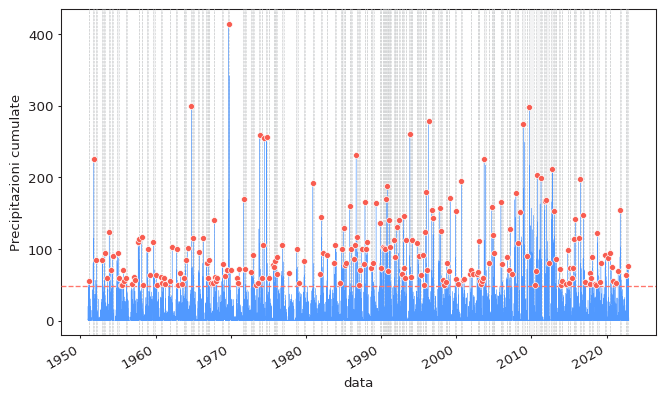

In [173]:
model2.plot_extremes(show_clusters=True)
plt.show()

In [174]:

print(len(model2.extremes))
model2.extremes

230


data
1951-03-05     55.0
1951-10-17    225.0
1952-02-06     85.0
1952-11-21     85.0
1953-03-16     95.0
              ...  
2021-03-22     52.0
2021-07-18     68.8
2021-10-25    153.9
2022-08-25     63.2
2022-11-26     75.9
Name: Precipitazioni cumulate, Length: 230, dtype: float64

In [175]:
# Ordino i massimi dal più grande al più piccolo
model2.extremes.sort_values(ascending=False)

data
1969-09-30    414.6
1964-09-30    300.0
2009-09-25    299.0
1996-05-10    278.9
2008-12-11    275.1
              ...  
1987-01-11     50.0
1958-05-20     49.4
2013-12-26     49.2
1995-09-28     49.0
1998-06-10     49.0
Name: Precipitazioni cumulate, Length: 230, dtype: float64

In [176]:
# Ottimizzazione della likelihood specificando di utilizzare la distribuzione GPD

model2.fit_model(distribution="genpareto", distribution_kwargs={})

In [177]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
# Nota: tempo di esecuzione di circa 2 minuti
summary2 = model2.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [178]:
summary2

,return value,lower ci,upper ci
return period,,,
1.0,103.565674,96.712152,120.901607
2.0,142.089532,130.513634,192.719653
5.0,201.101468,170.846758,392.535934
10.0,252.778965,196.516824,691.771794


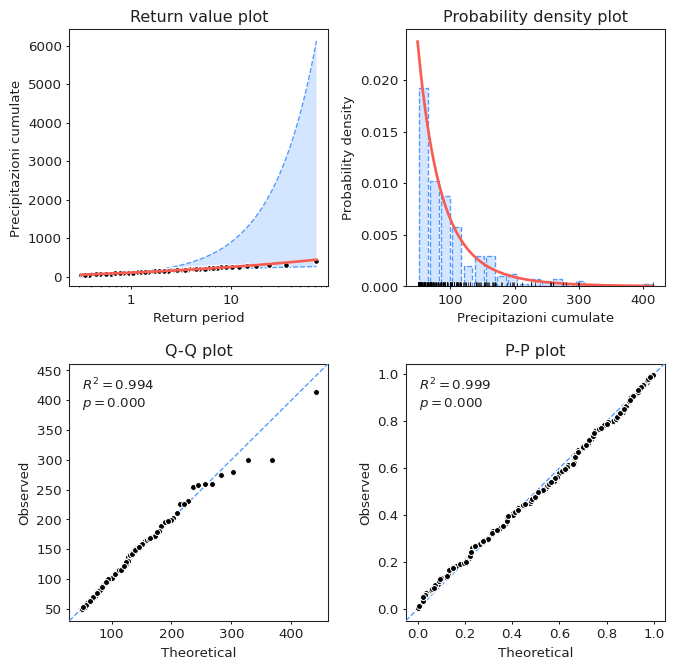

In [179]:
model2.plot_diagnostic(alpha=0.95)
plt.show()

In [180]:
# Distribuzione genpareto (GPD)
# parametri: c è ξ (forma) loc è μ (posizione), scale è σ (scala)
model2.distribution

              pyextremes distribution               
----------------------------------------------------
name: genpareto                                     
free parameters: c, loc, scale                      
fixed parameters: all parameters are free           
fitted parameters: c=0.183, loc=49.000, scale=42.178
----------------------------------------------------

## Threshold Selection

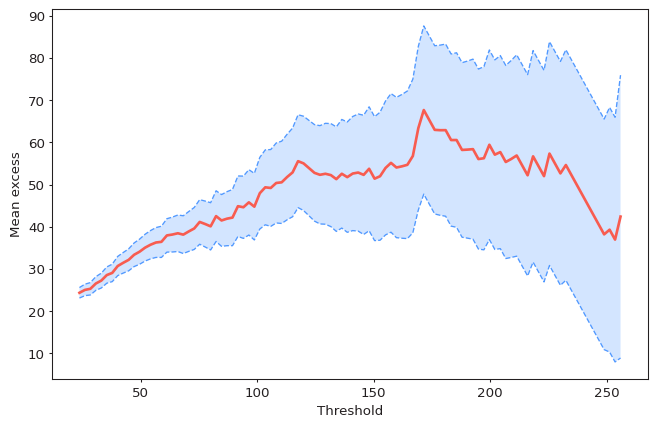

In [181]:
# Mean Residual Life
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#mean-residual-life
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(data)
plt.show()

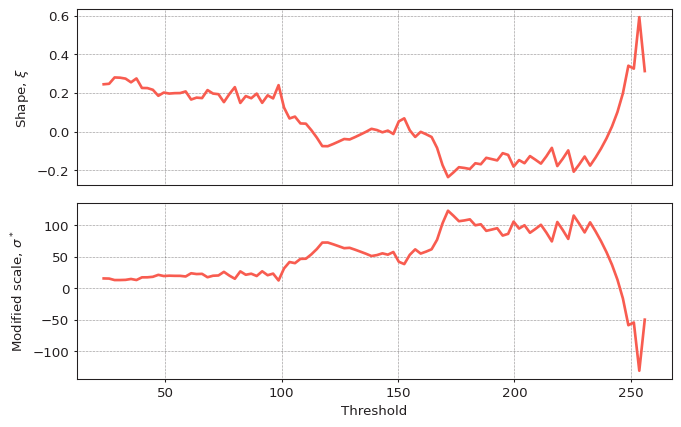

In [182]:
# Parameter Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#parameter-stability
from pyextremes import plot_parameter_stability

plot_parameter_stability(data)
plt.show()

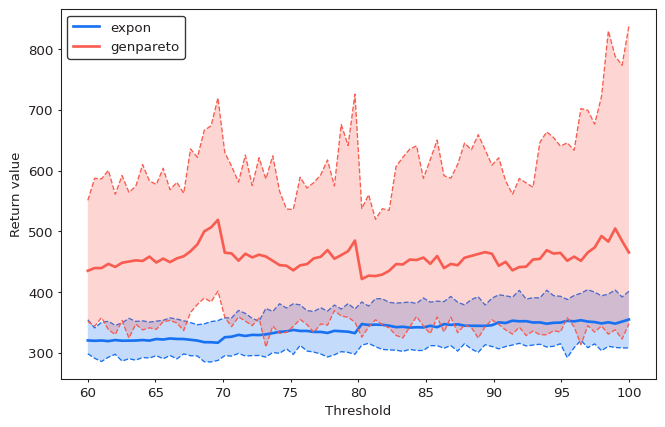

In [183]:
#Return Value Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#return-value-stability
from pyextremes import plot_return_value_stability
import numpy as np

plot_return_value_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95,
)
plt.show()

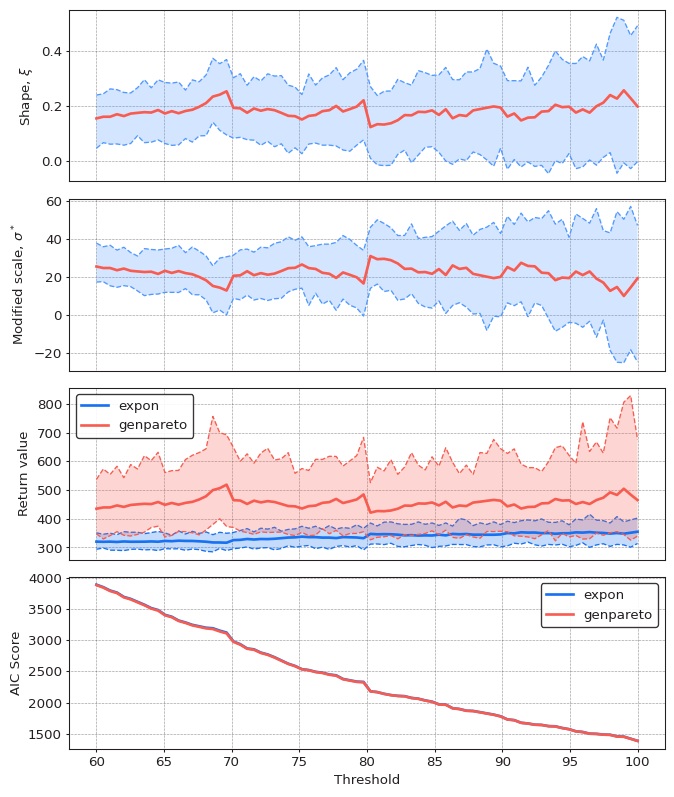

In [130]:
# Tutti i metodi insieme
from pyextremes import plot_threshold_stability

plot_threshold_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95
)
plt.show()

# Analisi per stazione: return levels (BM)
In questa sezione ripetiamo la stessa logica EVA usata prima, ma applicata alle singole stazioni.
L’obiettivo è confrontare i return levels tra stazioni.

In [137]:
import numpy as np
import pandas as pd
from pyextremes import EVA

# Copia e pulizia minima coerente con il notebook
df_st = series.copy()

df_st = df_st.dropna(subset=["data", "Precipitazioni cumulate"])
df_st = df_st[df_st["Precipitazioni cumulate"] >= 0]

# Coverage minima: tieni solo stazioni con almeno N anni di dati
MIN_YEARS = 30

years_cov = df_st.groupby("anagrafica")["data"].agg(lambda x: x.dt.year.nunique())
st_ok = years_cov[years_cov >= MIN_YEARS].index
df_st = df_st[df_st["anagrafica"].isin(st_ok)]

print("Stazioni totali nel CSV:", series["anagrafica"].nunique())
print(f"Stazioni con coverage >= {MIN_YEARS} anni:", df_st["anagrafica"].nunique())


Stazioni totali nel CSV: 31
Stazioni con coverage >= 30 anni: 10


In [138]:
# ============================================================
# SCOPO (perché esiste questo blocco)
# ============================================================
# In pyextremes, a seconda della versione installata, il metodo che
# restituisce i "return values / return levels" può cambiare:
#
# - Versioni "nuove": EVA.get_return_values(...) restituisce direttamente
#   un DataFrame con return value e intervalli di confidenza.
#
# - Versioni "vecchie": EVA.get_return_value(...) restituisce un valore
#   singolo per un return period, ma il formato dell'output può variare
#   (float, dict, tuple con CI, Series, ecc).
#
# Questo blocco serve a rendere il notebook robusto e riusabile:
# indipendentemente dalla versione, alla fine otteniamo SEMPRE una tabella
# standard con le colonne:
#   - return value
#   - lower ci
#   - upper ci
#
# In pratica: evitare crash e output incoerenti quando l'ambiente cambia
# (PC diverso, venv diverso, pyextremes aggiornato o meno).
# ============================================================

import numpy as np
import pandas as pd

def _parse_return_value_object(rv):
    """
    SCOPO:
    Normalizzare l'output restituito da EVA.get_return_value(...) in un formato unico.

    PERCHÉ:
    In alcune versioni/setting, get_return_value può restituire:
    - un numero semplice (float)
    - una tupla (rv, lo, hi)
    - una tupla (rv, (lo, hi))
    - un dict con chiavi diverse
    - una Series / oggetto pandas con campi simili
    - casi "non standard" o incompleti

    OUTPUT:
    Ritorna sempre una terna (value, lower_ci, upper_ci), con np.nan dove mancano CI.
    """


    # numerico puro
    if isinstance(rv, (int, float, np.floating)):
        return float(rv), np.nan, np.nan

    # tuple/list
    if isinstance(rv, (tuple, list)):
        if len(rv) == 0:
            return np.nan, np.nan, np.nan

        # (rv,)
        if len(rv) == 1:
            return float(rv[0]), np.nan, np.nan

        # (rv, (lo, hi))
        if len(rv) == 2 and isinstance(rv[1], (tuple, list)) and len(rv[1]) >= 2:
            return float(rv[0]), float(rv[1][0]), float(rv[1][1])

        # (rv, lo, hi)
        if len(rv) >= 3:
            return float(rv[0]), float(rv[1]), float(rv[2])

        # (rv, lo) non standard
        return float(rv[0]), float(rv[1]), np.nan

    # dict
    if isinstance(rv, dict):
        val = rv.get("return value", rv.get("return_value", rv.get("value", np.nan)))
        lo = rv.get("lower ci", rv.get("lower_ci", rv.get("lower", np.nan)))
        hi = rv.get("upper ci", rv.get("upper_ci", rv.get("upper", np.nan)))
        return float(val), float(lo) if lo is not None else np.nan, float(hi) if hi is not None else np.nan

    # pandas Series-like
    if hasattr(rv, "to_dict"):
        d = rv.to_dict()
        val = d.get("return value", d.get("return_value", d.get("value", np.nan)))
        lo = d.get("lower ci", d.get("lower_ci", d.get("lower", np.nan)))
        hi = d.get("upper ci", d.get("upper_ci", d.get("upper", np.nan)))
        return float(val), float(lo) if lo is not None else np.nan, float(hi) if hi is not None else np.nan

    # fallback ultimo: prova a castare a float (se fallisce, NaN)
    try:
        return float(rv), np.nan, np.nan
    except Exception:
        return np.nan, np.nan, np.nan


def get_return_values_compat(eva_obj, return_periods, alpha=0.95, n_samples=200):
    """
    SCOPO:
    Ottenere return levels per più return periods (es. 10, 20, 50 anni)
    in modo compatibile tra diverse versioni di pyextremes.

    COSA FACCIAMO:
    1) Se l'oggetto EVA espone get_return_values(...), lo usiamo.
       Questo è il caso "moderno" e produce direttamente un DataFrame.
    2) Se invece c'è solo get_return_value(...), lo chiamiamo per ogni return period,
       e normalizziamo l'output con _parse_return_value_object.
    3) In entrambi i casi ritorniamo un DataFrame standard indicizzato per return period.

    PERCHÉ:
    - Evita errori come AttributeError (metodo mancante)
    - Evita TypeError/JSON/tuple parsing ecc.
    - Permette di mantenere invariato il resto del notebook.
    """
    # API nuova
    if hasattr(eva_obj, "get_return_values"):
        rv = eva_obj.get_return_values(
            return_period=list(return_periods),
            alpha=alpha,
            n_samples=n_samples
        )
        # assicura nomi colonne standard (se già ok, non cambia nulla)
        cols = {c: c for c in rv.columns}
        # alcune versioni usano underscore
        if "return_value" in rv.columns: cols["return_value"] = "return value"
        if "lower_ci" in rv.columns: cols["lower_ci"] = "lower ci"
        if "upper_ci" in rv.columns: cols["upper_ci"] = "upper ci"
        rv = rv.rename(columns=cols)
        return rv

    # API vecchia singolare
    if hasattr(eva_obj, "get_return_value"):
        rows = []
        for rp in return_periods:
            raw = eva_obj.get_return_value(
                return_period=rp,
                alpha=alpha,
                n_samples=n_samples
            )
            val, lo, hi = _parse_return_value_object(raw)
            rows.append({
                "return_period": rp,
                "return value": val,
                "lower ci": lo,
                "upper ci": hi
            })
        return pd.DataFrame(rows).set_index("return_period")

    raise AttributeError(
        "La tua versione di pyextremes non espone metodi per return values "
        "(get_return_values / get_return_value)."
    )


In [139]:
# ============================================================
# BLOCCO: Extreme Value Analysis per singola stazione (Block Maxima)
# ============================================================
#
# SCOPO
# Calcolare i livelli di ritorno delle precipitazioni estreme (RL10, RL20, RL50)
# per una singola stazione meteorologica, utilizzando il metodo Block Maxima
# e la distribuzione Generalized Extreme Value (GEV).
#
# COSA FACCIAMO
# 1) Costruiamo la serie temporale giornaliera della stazione.
# 2) Estraiamo i massimi annuali (RX1day) tramite il metodo Block Maxima.
# 3) Fittiamo un modello EVT (GEV) ai massimi annuali.
# 4) Stimiamo i livelli di ritorno per diversi periodi (10, 20, 50 anni),
#    includendo intervalli di confidenza tramite bootstrap.
# 5) Restituiamo un dizionario standardizzato con:
#    - numero osservazioni totali
#    - numero di massimi annuali utilizzati
#    - RL e relativi limiti di confidenza.
#
# PERCHÉ
# Questo approccio consente di:
# - quantificare la rarità statistica degli eventi di pioggia intensa;
# - confrontare l’intensità degli estremi tra stazioni diverse;
# - fornire valori di progetto per ingegneria idraulica e analisi del rischio;
# - mantenere la pipeline robusta e riproducibile.
#
# NOTA
# Viene applicato un controllo minimo sulla lunghezza della serie (≥10 anni)
# per evitare stime instabili dovute a dataset troppo brevi.
# ============================================================

from pyextremes import EVA

def bm_return_levels_for_station(
    station_df,
    return_periods=(10, 20, 50),
    block_size="365.2425D",
    alpha=0.95,
    n_samples=200
):
    s = (
        station_df
        .set_index("data")["Precipitazioni cumulate"]
        .sort_index()
        .astype(float)
        .dropna()
    )

    # minimo dati (evita fit instabile)
    if len(s) < 365 * 10:
        return None

    m = EVA(s)
    m.get_extremes(method="BM", block_size=block_size, errors="coerce")
    m.fit_model()

    rv = get_return_values_compat(m, return_periods=return_periods, alpha=alpha, n_samples=n_samples)

    out = {
        "n_obs": int(len(s)),
        "n_bm": int(len(m.extremes)),
    }
    for rp in return_periods:
        out[f"RL{rp}"] = float(rv.loc[rp, "return value"])
        out[f"RL{rp}_lo"] = float(rv.loc[rp, "lower ci"])
        out[f"RL{rp}_hi"] = float(rv.loc[rp, "upper ci"])

    return out


In [140]:
# ============================================================
# BLOCCO: Costruzione della tabella dei Return Levels per tutte le stazioni
# ============================================================
#
# SCOPO
# Applicare l’analisi Extreme Value Analysis (Block Maxima) a tutte le stazioni
# meteorologiche disponibili e costruire una tabella riassuntiva dei livelli
# di ritorno (RL10, RL20, RL50) per ciascuna stazione.
#
# COSA FACCIAMO
# 1) Raggruppiamo il dataset df_st per stazione (campo "anagrafica").
# 2) Per ogni stazione richiamiamo la funzione bm_return_levels_for_station:
#    - estrazione massimi annuali
#    - fit del modello GEV
#    - stima dei return levels con intervalli di confidenza.
# 3) Scartiamo automaticamente le stazioni con serie troppo corte
#    (la funzione restituisce None).
# 4) Aggiungiamo metadati della stazione (nome e rete di appartenenza).
# 5) Costruiamo un DataFrame finale ordinato per RL50 decrescente.
#
# PERCHÉ
# Questo passaggio produce:
# - una vista comparabile degli estremi di precipitazione tra stazioni;
# - una base dati per analisi spaziali dei return levels;
# - l’input per il successivo Quality Control sulle stime;
# - un ranking utile per identificare le aree con eventi più intensi.
#
# OUTPUT
# rl_station:
# - una riga per stazione
# - colonne con n_obs, n_bm, RL10, RL20, RL50 e relativi CI
# - ordinamento per RL50 per evidenziare gli estremi più severi.
# ============================================================


rows = []

for st, sdf in df_st.groupby("anagrafica"):
    res = bm_return_levels_for_station(
        sdf,
        return_periods=(10, 20, 50),
        alpha=0.95,
        n_samples=200
    )
    if res is None:
        continue

    res["anagrafica"] = st
    res["rete"] = sdf["rete"].iloc[0]
    rows.append(res)

rl_station = pd.DataFrame(rows).sort_values("RL50", ascending=False).reset_index(drop=True)

print("Stazioni analizzate (BM):", len(rl_station))
rl_station.head(10)


Stazioni analizzate (BM): 10


,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,anagrafica,rete
0,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,4.560002e+02,508.783863,326.382268,9.875193e+02,PALERMO/PUNTA RAISI,Sinottica
1,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,2.321469e+02,229.604235,189.403441,2.801234e+02,MELILLI,RETE SICILIA OSS. ACQUE TEMP
2,21096,72,141.201985,113.842751,459.144541,174.513237,131.502792,8.361946e+03,223.290569,154.422171,7.643712e+05,CATANIA/FONTANAROSS,Sinottica
3,22983,72,131.358607,112.266965,160619.310771,156.480439,124.802423,9.725856e+06,192.182495,141.483102,1.971441e+09,S.STEFANO DI BRIGA,RETE SICILIA OSS. ACQUE TEMP
4,25759,72,106.005918,91.522793,119.824645,123.459353,105.509413,1.392914e+02,146.051035,124.499441,1.649531e+02,COZZO SPADARO,Sinottica
5,16103,53,102.210111,90.501056,113.606787,118.380918,104.452126,1.324851e+02,139.312370,122.072527,1.570401e+02,MIRABELLA IMBACCARI,RETE SICILIA OSS. ACQUE TEMP
6,21938,62,82.057849,68.057057,97.199959,101.356083,80.923264,1.235922e+02,130.466824,97.667192,1.778280e+02,TRAPANI/BIRGI,Sinottica
7,19115,72,94.779074,85.846538,107.150491,109.538222,99.171511,1.252775e+02,128.642425,115.454195,1.487256e+02,MAZZARINO,RETE SICILIA OSS. ACQUE TEMP
8,20029,72,85.472665,76.486468,93.341085,96.344104,84.890500,1.059989e+02,110.416066,95.901595,1.222863e+02,PALERMO IST.ZOOTECN.,RETE SICILIA OSS. ACQUE TEMP
9,11029,46,68.958935,60.140510,77.027471,79.786640,67.510035,9.073031e+01,93.801993,77.835314,1.084477e+02,CAMPOREALE,RETE SICILIA OSS. ACQUE TEMP


In [141]:
# ============================================================
# BLOCCO: QC1 – Preparazione metriche per il Quality Control
# ============================================================
#
# SCOPO
# Costruire una versione estesa della tabella dei return levels per stazione
# arricchita con:
# - copertura temporale delle osservazioni
# - metriche di stabilità degli intervalli di confidenza
#
# Questa tabella sarà la base per il Quality Control delle stime EVT.
#
# COSA FACCIAMO
# 1) Calcoliamo per ogni stazione il numero di anni distinti con dati disponibili.
#    Questo fornisce una misura della copertura temporale della serie.
#
# 2) Uniamo questa informazione alla tabella dei return levels (rl_station)
#    ottenendo una nuova tabella rl_station_qc.
#
# 3) Calcoliamo, per ciascun return period (10, 20, 50 anni):
#    - ampiezza dell’intervallo di confidenza (CI width)
#    - rapporto tra ampiezza CI e valore stimato (CI ratio)
#
# PERCHÉ
# Le stime EVT possono diventare instabili quando:
# - la serie storica è troppo corta
# - il numero di massimi annuali è limitato
# - gli intervalli di confidenza risultano eccessivamente ampi
#
# Queste metriche permettono di:
# - identificare automaticamente stazioni con stime poco affidabili
# - applicare criteri oggettivi di esclusione nel QC2
# - mantenere trasparenza sulle incertezze delle stime
#
# OUTPUT
# rl_station_qc:
# - contiene i return levels per stazione
# - aggiunge n_years di copertura
# - aggiunge metriche CI per successivi controlli qualità
# ============================================================

# 1) coverage anni per stazione
cov = (
    df_st.groupby("anagrafica")["data"]
    .agg(lambda x: x.dt.year.nunique())
    .rename("n_years")
    .reset_index()
)

# 2) crea rl_station_qc facendo merge su anagrafica
rl_station_qc = rl_station.merge(cov, on="anagrafica", how="left")

# 3) CI width/ratio (serve a QC2)
for rp in (10, 20, 50):
    rl_station_qc[f"RL{rp}_ci_width"] = rl_station_qc[f"RL{rp}_hi"] - rl_station_qc[f"RL{rp}_lo"]
    rl_station_qc[f"RL{rp}_ci_ratio"] = rl_station_qc[f"RL{rp}_ci_width"] / rl_station_qc[f"RL{rp}"]

print("Colonne disponibili in rl_station_qc:")
print(list(rl_station_qc.columns))
rl_station_qc.head(3)


Colonne disponibili in rl_station_qc:
['n_obs', 'n_bm', 'RL10', 'RL10_lo', 'RL10_hi', 'RL20', 'RL20_lo', 'RL20_hi', 'RL50', 'RL50_lo', 'RL50_hi', 'anagrafica', 'rete', 'n_years', 'RL10_ci_width', 'RL10_ci_ratio', 'RL20_ci_width', 'RL20_ci_ratio', 'RL50_ci_width', 'RL50_ci_ratio']


,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,anagrafica,rete,n_years,RL10_ci_width,RL10_ci_ratio,RL20_ci_width,RL20_ci_ratio,RL50_ci_width,RL50_ci_ratio
0,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,456.000174,508.783863,326.382268,987.519294,PALERMO/PUNTA RAISI,Sinottica,58,140.613996,0.698191,244.287626,0.803533,661.137026,1.299446
1,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,232.146855,229.604235,189.403441,280.123380,MELILLI,RETE SICILIA OSS. ACQUE TEMP,34,58.688844,0.361269,71.964177,0.375361,90.719938,0.395114
2,21096,72,141.201985,113.842751,459.144541,174.513237,131.502792,8361.946366,223.290569,154.422171,764371.182450,CATANIA/FONTANAROSS,Sinottica,63,345.301790,2.445446,8230.443575,47.162288,764216.760279,3422.521447


In [142]:
# ============================================================
# BLOCCO: QC2 – Identificazione delle stazioni con stime instabili
# ============================================================
#
# SCOPO
# Applicare un controllo qualità automatico sulle stime dei return levels
# per individuare stazioni con risultati statisticamente instabili.
#
# L’obiettivo è costruire:
# - un dataset completo (rl_station_qc) con flag diagnostici
# - un dataset "clean" (rl_station_clean) con sole stazioni affidabili
#
# Questo evita che serie troppo corte o modelli mal condizionati
# falsino i confronti spaziali dei livelli di ritorno.
#
# ------------------------------------------------------------
# COSA SONO I PARAMETRI UTILIZZATI
#
# n_years:
#   Numero di anni distinti con dati disponibili per la stazione.
#   Misura la copertura temporale della serie.
#
# n_bm:
#   Numero di massimi annuali effettivamente utilizzati dal modello BM.
#   Se basso, il fit della GEV diventa instabile.
#
# RL50:
#   Return Level a 50 anni.
#   Quantità di pioggia giornaliera che il modello stima venga superata,
#   in media, una volta ogni 50 anni (probabilità annuale 1/50 = 2%).
#
# RL50_lo / RL50_hi:
#   Limiti inferiore e superiore dell’intervallo di confidenza
#   della stima RL50 calcolato via bootstrap.
#
# RL50_ci_ratio:
#   Rapporto tra ampiezza dell’intervallo di confidenza e valore RL50.
#   Valori elevati indicano stima poco precisa.
#
# ------------------------------------------------------------
# SOGLIE DI QUALITY CONTROL
#
# MIN_YEARS_QC = 30
#   Numero minimo di anni di dati richiesto.
#   Sotto questa soglia le stime EVT sono considerate poco affidabili.
#
# MIN_BM_QC = 25
#   Numero minimo di massimi annuali richiesti per un fit stabile.
#
# MAX_RL50_HI = 1000 mm
#   Soglia semplice per intercettare casi in cui l’estremo superiore
#   dell’intervallo di confidenza "esplode" numericamente.
#
# MAX_CI_RATIO_RL50 = 3.0
#   Se l’intervallo di confidenza è più largo di 3 volte il valore stimato,
#   la stima è considerata instabile.
#
# ------------------------------------------------------------
# COSA PRODUCE QUESTO BLOCCO
#
# flag_low_coverage:
#   True se la stazione ha pochi anni o pochi massimi annuali.
#
# flag_ci_explodes:
#   True se RL50_hi supera la soglia massima definita.
#
# flag_ci_too_wide:
#   True se l’intervallo di confidenza è troppo ampio rispetto al valore stimato.
#
# flag_unstable:
#   True se almeno uno dei flag precedenti è attivo.
#   La stazione viene quindi esclusa dal dataset clean.
#
# rl_station_clean:
#   Dataset finale con sole stazioni che superano tutti i controlli.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI FINALI
#
# Le stampe finali riportano:
#
# - Totale stazioni: quante stazioni sono state analizzate
# - Flagged unstable: quante stazioni hanno stime instabili
# - Stazioni usabili (clean): quante restano per le analisi affidabili
#
# La tabella diagnostica mostra per ogni stazione:
# - copertura temporale (n_years)
# - numero massimi annuali (n_bm)
# - RL50 e intervallo di confidenza
# - motivi dell’eventuale esclusione
#
# Questo rende il processo trasparente e riproducibile.
# ============================================================


# 0) normalizza n_years
if "n_years" not in rl_station_qc.columns:
    if "n_years_y" in rl_station_qc.columns:
        rl_station_qc["n_years"] = rl_station_qc["n_years_y"]
    elif "n_years_x" in rl_station_qc.columns:
        rl_station_qc["n_years"] = rl_station_qc["n_years_x"]
    else:
        raise ValueError("QC2: non trovo n_years né n_years_x/y. Esegui QC1 correttamente.")

# 1) guardrail: controlla le colonne necessarie
required_cols = ["n_years", "n_bm", "RL50_hi", "RL50_ci_ratio"]
missing = [c for c in required_cols if c not in rl_station_qc.columns]
if missing:
    raise ValueError(f"QC2: mancano colonne in rl_station_qc: {missing}.")

# 2) soglie (regolabili senza cambiare logica)
MIN_YEARS_QC = 30
MIN_BM_QC = 25

#RL50 La quantità di pioggia giornaliera che ci si aspetta venga superata, in media, una volta ogni 50 anni.
MAX_RL50_HI = 1000
MAX_CI_RATIO_RL50 = 3.0

# 3) flag
rl_station_qc["flag_low_coverage"] = (rl_station_qc["n_years"] < MIN_YEARS_QC) | (rl_station_qc["n_bm"] < MIN_BM_QC)
rl_station_qc["flag_ci_explodes"] = (rl_station_qc["RL50_hi"] > MAX_RL50_HI)
rl_station_qc["flag_ci_too_wide"] = (rl_station_qc["RL50_ci_ratio"] > MAX_CI_RATIO_RL50) | (rl_station_qc["RL50_ci_ratio"].isna())

rl_station_qc["flag_unstable"] = rl_station_qc[["flag_low_coverage", "flag_ci_explodes", "flag_ci_too_wide"]].any(axis=1)

# 4) clean
rl_station_clean = rl_station_qc[~rl_station_qc["flag_unstable"]].copy()

# 5) report rapido
print("Totale stazioni:", len(rl_station_qc))
print("Flagged unstable:", int(rl_station_qc["flag_unstable"].sum()))
print("Stazioni usabili (clean):", len(rl_station_clean))

# 6) diagnostica top 20
rl_station_qc.sort_values(["flag_unstable", "RL50"], ascending=[False, False])[
    ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio",
     "flag_low_coverage","flag_ci_explodes","flag_ci_too_wide"]
].head(20)


Totale stazioni: 10
Flagged unstable: 2
Stazioni usabili (clean): 8


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_low_coverage,flag_ci_explodes,flag_ci_too_wide
2,Sinottica,CATANIA/FONTANAROSS,63,72,223.290569,154.422171,7.643712e+05,3.422521e+03,False,True,True
3,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,64,72,192.182495,141.483102,1.971441e+09,1.025817e+07,False,True,True
0,Sinottica,PALERMO/PUNTA RAISI,58,59,508.783863,326.382268,9.875193e+02,1.299446e+00,False,False,False
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,53,229.604235,189.403441,2.801234e+02,3.951144e-01,False,False,False
4,Sinottica,COZZO SPADARO,72,72,146.051035,124.499441,1.649531e+02,2.769830e-01,False,False,False
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,53,139.312370,122.072527,1.570401e+02,2.510014e-01,False,False,False
6,Sinottica,TRAPANI/BIRGI,62,62,130.466824,97.667192,1.778280e+02,6.144153e-01,False,False,False
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,72,128.642425,115.454195,1.487256e+02,2.586350e-01,False,False,False
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,72,110.416066,95.901595,1.222863e+02,2.389567e-01,False,False,False
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,46,93.801993,77.835314,1.084477e+02,3.263516e-01,False,False,False


In [184]:
from IPython.display import display

# --- PRINT QC: quante stazioni passano e perché falliscono ---
print("Colonne in rl_station_qc:", list(rl_station_qc.columns))
print("Totale stazioni:", len(rl_station_qc))
print("Unstable:", int(rl_station_qc["flag_unstable"].sum()))
print("Clean:", len(rl_station_clean))

# riassunto motivi di esclusione
cols_flags = ["flag_low_coverage", "flag_ci_explodes", "flag_ci_too_wide"]
summary_flags = rl_station_qc[cols_flags].sum().sort_values(ascending=False)
print("\nMotivi di esclusione (conteggi):")
display(summary_flags.to_frame("count"))

# top 15 stazioni con stime più “rischiose” (CI ratio alto) tra quelle analizzate
cols_show = ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio"] + cols_flags + ["flag_unstable"]
display(
    rl_station_qc.sort_values(["flag_unstable","RL50_ci_ratio","RL50_hi"], ascending=[False,False,False])[cols_show].head(15)
)


Colonne in rl_station_qc: ['n_obs', 'n_bm', 'RL10', 'RL10_lo', 'RL10_hi', 'RL20', 'RL20_lo', 'RL20_hi', 'RL50', 'RL50_lo', 'RL50_hi', 'anagrafica', 'rete', 'n_years', 'RL10_ci_width', 'RL10_ci_ratio', 'RL20_ci_width', 'RL20_ci_ratio', 'RL50_ci_width', 'RL50_ci_ratio', 'flag_low_coverage', 'flag_ci_explodes', 'flag_ci_too_wide', 'flag_unstable']
Totale stazioni: 10
Unstable: 2
Clean: 8

Motivi di esclusione (conteggi):


,count
flag_ci_explodes,2
flag_ci_too_wide,2
flag_low_coverage,0


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_low_coverage,flag_ci_explodes,flag_ci_too_wide,flag_unstable
3,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,64,72,192.182495,141.483102,1.971441e+09,1.025817e+07,False,True,True,True
2,Sinottica,CATANIA/FONTANAROSS,63,72,223.290569,154.422171,7.643712e+05,3.422521e+03,False,True,True,True
0,Sinottica,PALERMO/PUNTA RAISI,58,59,508.783863,326.382268,9.875193e+02,1.299446e+00,False,False,False,False
6,Sinottica,TRAPANI/BIRGI,62,62,130.466824,97.667192,1.778280e+02,6.144153e-01,False,False,False,False
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,53,229.604235,189.403441,2.801234e+02,3.951144e-01,False,False,False,False
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,46,93.801993,77.835314,1.084477e+02,3.263516e-01,False,False,False,False
4,Sinottica,COZZO SPADARO,72,72,146.051035,124.499441,1.649531e+02,2.769830e-01,False,False,False,False
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,72,128.642425,115.454195,1.487256e+02,2.586350e-01,False,False,False,False
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,53,139.312370,122.072527,1.570401e+02,2.510014e-01,False,False,False,False
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,72,110.416066,95.901595,1.222863e+02,2.389567e-01,False,False,False,False


In [143]:
# ============================================================
# BLOCCO: QC3 – Esportazione dei risultati finali
# ============================================================
#
# SCOPO
# Salvare su file i risultati dell’analisi EVT per stazione,
# distinguendo tra:
# - dataset completo con flag di Quality Control
# - dataset "clean" con sole stazioni affidabili
#
# Questo rende i risultati riutilizzabili fuori dal notebook
# per reportistica, mappe, analisi GIS o ulteriori elaborazioni.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Salviamo il dataset completo rl_station_qc:
#    Contiene tutte le stazioni analizzate con:
#    - return levels
#    - intervalli di confidenza
#    - metriche QC
#    - flag di instabilità
#
# 2) Salviamo il dataset rl_station_clean:
#    Contiene solo le stazioni che superano il controllo qualità.
#
# 3) Creiamo una versione "ridotta" delle tabelle
#    contenente solo le colonne essenziali per report e visualizzazioni:
#    - metadati della stazione
#    - return levels RL10, RL20, RL50
#    - intervalli di confidenza
#    - indice di stabilità della stima
#
# ------------------------------------------------------------
# PERCHÉ
#
# La separazione tra:
# - dataset completo (trasparenza totale)
# - dataset clean (analisi affidabili)
#
# consente di:
# - documentare quali stazioni sono state escluse e perché
# - evitare di propagare stime instabili nelle analisi successive
# - fornire direttamente tabelle pronte per report e mappe tematiche
#
# ------------------------------------------------------------
# COME LEGGERE I FILE SALVATI
#
# 1) sicilia_return_levels_BM_per_stazione_QC.csv
#    Tutte le stazioni + tutte le metriche QC
#
# 2) sicilia_return_levels_BM_per_stazione_clean_QC.csv
#    Solo stazioni affidabili + tutte le metriche QC
#
# 3) sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv
#    Dataset completo con sole colonne essenziali
#
# 4) sicilia_return_levels_BM_per_stazione_clean_cols.csv
#    Dataset clean con sole colonne essenziali
#
# Questi file rappresentano l’output finale dell’intera pipeline.
# ============================================================


# ---- QC3: export risultati ----

# Salvataggi completi
rl_station_qc.to_csv("sicilia_return_levels_BM_per_stazione_QC.csv", index=False)
rl_station_clean.to_csv("sicilia_return_levels_BM_per_stazione_clean_QC.csv", index=False)

print("Salvati:")
print("- sicilia_return_levels_BM_per_stazione_QC.csv")
print("- sicilia_return_levels_BM_per_stazione_clean_QC.csv")

# Output ridotto (pulito) da usare nel report
cols_out = ["rete", "anagrafica", "n_years", "n_obs", "n_bm",
            "RL10", "RL10_lo", "RL10_hi",
            "RL20", "RL20_lo", "RL20_hi",
            "RL50", "RL50_lo", "RL50_hi",
            "RL50_ci_ratio", "flag_unstable"]

# flag_unstable non esiste in rl_station_clean (per definizione è False), quindi lo aggiungo per coerenza
if "flag_unstable" not in rl_station_clean.columns:
    rl_station_clean["flag_unstable"] = False

rl_station_qc[cols_out].to_csv("sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv", index=False)
rl_station_clean[cols_out].to_csv("sicilia_return_levels_BM_per_stazione_clean_cols.csv", index=False)

print("Salvati anche:")
print("- sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv")
print("- sicilia_return_levels_BM_per_stazione_clean_cols.csv")

rl_station_clean[cols_out].head(10)


Salvati:
- sicilia_return_levels_BM_per_stazione_QC.csv
- sicilia_return_levels_BM_per_stazione_clean_QC.csv
Salvati anche:
- sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv
- sicilia_return_levels_BM_per_stazione_clean_cols.csv


,rete,anagrafica,n_years,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_unstable
0,Sinottica,PALERMO/PUNTA RAISI,58,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,456.000174,508.783863,326.382268,987.519294,1.299446,False
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,232.146855,229.604235,189.403441,280.123380,0.395114,False
4,Sinottica,COZZO SPADARO,72,25759,72,106.005918,91.522793,119.824645,123.459353,105.509413,139.291446,146.051035,124.499441,164.953096,0.276983,False
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,16103,53,102.210111,90.501056,113.606787,118.380918,104.452126,132.485055,139.312370,122.072527,157.040127,0.251001,False
6,Sinottica,TRAPANI/BIRGI,62,21938,62,82.057849,68.057057,97.199959,101.356083,80.923264,123.592152,130.466824,97.667192,177.828002,0.614415,False
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,19115,72,94.779074,85.846538,107.150491,109.538222,99.171511,125.277497,128.642425,115.454195,148.725633,0.258635,False
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,20029,72,85.472665,76.486468,93.341085,96.344104,84.890500,105.998913,110.416066,95.901595,122.286253,0.238957,False
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,11029,46,68.958935,60.140510,77.027471,79.786640,67.510035,90.730312,93.801993,77.835314,108.447747,0.326352,False


In [185]:
from IPython.display import display

# --- TABELLINA: statistiche riassuntive sui return levels (solo stazioni clean) ---
cols_rl = ["RL10","RL20","RL50"]
desc = rl_station_clean[cols_rl].describe(percentiles=[0.5, 0.75, 0.9, 0.95]).T
desc = desc[["count","mean","std","min","50%","75%","90%","95%","max"]]
print("Statistiche RL (mm) sulle stazioni CLEAN:")
display(desc)

# --- TOP 10 stazioni per RL50 ---
top10 = rl_station_clean.sort_values("RL50", ascending=False)[
    ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio"]
].head(10)

print("Top 10 stazioni per RL50 (CLEAN):")
display(top10)


Statistiche RL (mm) sulle stazioni CLEAN:


,count,mean,std,min,50%,75%,90%,95%,max
RL10,8.0,112.916786,45.374210,68.958935,98.494592,120.117438,174.135720,187.766730,201.397740
RL20,8.0,140.575270,73.937801,79.786640,113.959570,140.524494,225.409017,264.712969,304.016921
RL50,8.0,185.884851,136.514535,93.801993,134.889597,166.939335,313.358124,411.070993,508.783863


Top 10 stazioni per RL50 (CLEAN):


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio
0,Sinottica,PALERMO/PUNTA RAISI,58,59,508.783863,326.382268,987.519294,1.299446
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,53,229.604235,189.403441,280.123380,0.395114
4,Sinottica,COZZO SPADARO,72,72,146.051035,124.499441,164.953096,0.276983
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,53,139.312370,122.072527,157.040127,0.251001
6,Sinottica,TRAPANI/BIRGI,62,62,130.466824,97.667192,177.828002,0.614415
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,72,128.642425,115.454195,148.725633,0.258635
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,72,110.416066,95.901595,122.286253,0.238957
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,46,93.801993,77.835314,108.447747,0.326352


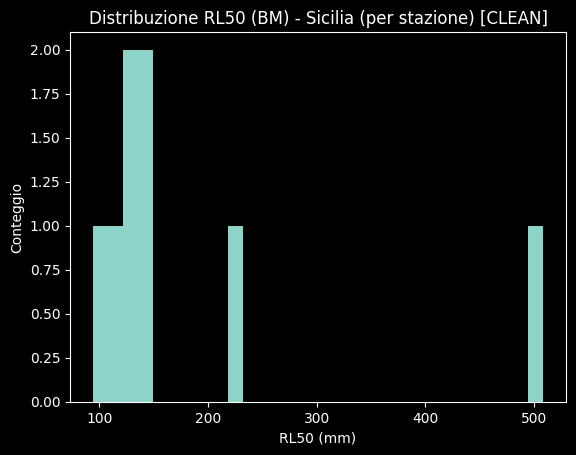

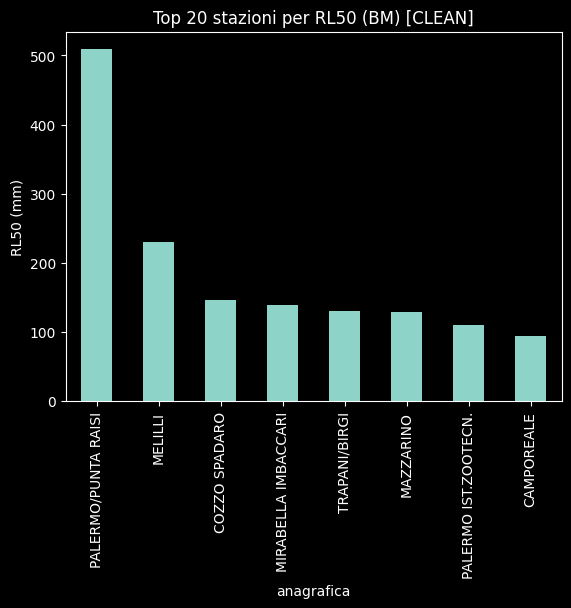

In [144]:
# ============================================================
# BLOCCO: Visualizzazione dei Return Levels (RL50) per stazione
# ============================================================
#
# SCOPO
# Visualizzare la distribuzione spaziale dei livelli di ritorno a 50 anni (RL50)
# per le stazioni siciliane che hanno superato il Quality Control.
#
# Questi grafici permettono di:
# - comprendere la variabilità degli estremi di precipitazione tra stazioni
# - identificare le aree con eventi più intensi
# - supportare interpretazioni fisiche e applicazioni di rischio
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Istogramma della distribuzione di RL50:
#    Mostra come si distribuiscono i livelli di ritorno a 50 anni
#    tra tutte le stazioni del dataset clean.
#
# 2) Bar chart delle Top 20 stazioni:
#    Ordina le stazioni per RL50 decrescente
#    e visualizza le 20 con i livelli di ritorno più elevati.
#
# ------------------------------------------------------------
# COME LEGGERE I GRAFICI
#
# Istogramma RL50:
# - Asse X: valore RL50 in millimetri
# - Asse Y: numero di stazioni che presentano quel range di RL50
# - Permette di capire se gli estremi sono concentrati
#   o se esiste forte dispersione spaziale.
#
# Top 20 stazioni:
# - Ogni barra rappresenta una stazione meteorologica
# - L’altezza indica il livello di ritorno RL50 stimato
# - Le stazioni più alte rappresentano le aree
#   con potenziale di precipitazioni estreme più intense.
#
# ------------------------------------------------------------
# PERCHÉ
#
# La rappresentazione grafica dei return levels:
# - rende immediata l’interpretazione dei risultati EVT
# - evidenzia pattern territoriali
# - fornisce un supporto diretto a pianificazione
#   e progettazione basata su livelli di ritorno.
# ============================================================

import matplotlib.pyplot as plt

plt.figure()
rl_station_clean["RL50"].plot(kind="hist", bins=30)
plt.title("Distribuzione RL50 (BM) - Sicilia (per stazione) [CLEAN]")
plt.xlabel("RL50 (mm)")
plt.ylabel("Conteggio")
plt.show()

plt.figure()
top20 = rl_station_clean.sort_values("RL50", ascending=False).head(20).set_index("anagrafica")["RL50"]
top20.plot(kind="bar")
plt.title("Top 20 stazioni per RL50 (BM) [CLEAN]")
plt.ylabel("RL50 (mm)")
plt.show()


In [145]:
# ============================================================
# BLOCCO: Analisi delle stazioni escluse dal Quality Control
# ============================================================
#
# SCOPO
# Isolare e analizzare le stazioni che sono state escluse dal dataset clean
# perché presentano stime EVT considerate statisticamente instabili.
#
# Questo passaggio serve a:
# - mantenere trasparenza sul processo di esclusione
# - documentare le cause dell’instabilità
# - evitare che le stazioni escluse vengano interpretate come assenza di dati
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Selezioniamo tutte le stazioni con flag_unstable = True.
#
# 2) Stampiamo il numero totale di stazioni escluse.
#
# 3) Ordiniamo le stazioni escluse per RL50 decrescente
#    per evidenziare i casi in cui valori elevati derivano
#    da instabilità numerica piuttosto che da estremi reali ben stimati.
#
# 4) Mostriamo, per ciascuna stazione:
#    - copertura temporale (n_years)
#    - numero di massimi annuali (n_bm)
#    - RL50 e intervalli di confidenza
#    - indicatori che spiegano il motivo dell’esclusione.
#
# ------------------------------------------------------------
# COME LEGGERE LA TABELLA
#
# flag_low_coverage = True
#   La stazione ha pochi anni di dati o pochi massimi annuali.
#
# flag_ci_explodes = True
#   L’estremo superiore dell’intervallo di confidenza RL50
#   assume valori numericamente molto elevati.
#
# flag_ci_too_wide = True
#   L’intervallo di confidenza è troppo ampio rispetto al valore stimato.
#
# Se almeno uno di questi flag è True,
# la stazione viene classificata come "instabile".
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questa tabella consente di:
# - giustificare oggettivamente l’esclusione delle stazioni
# - dimostrare che il filtraggio non è arbitrario
# - mantenere tracciabilità completa del Quality Control
# ============================================================


excluded = rl_station_qc[rl_station_qc["flag_unstable"]].copy()

print("Stazioni escluse:", len(excluded))
excluded.sort_values("RL50", ascending=False)[
    ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio",
     "flag_low_coverage","flag_ci_explodes","flag_ci_too_wide"]
].head(30)


Stazioni escluse: 2


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_low_coverage,flag_ci_explodes,flag_ci_too_wide
2,Sinottica,CATANIA/FONTANAROSS,63,72,223.290569,154.422171,7.643712e+05,3.422521e+03,False,True,True
3,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,64,72,192.182495,141.483102,1.971441e+09,1.025817e+07,False,True,True


In [146]:
# ============================================================
# BLOCCO: Riepilogo finale del Quality Control
# ============================================================
#
# SCOPO
# Fornire un riepilogo numerico immediato dell’impatto del Quality Control
# sull’insieme delle stazioni analizzate.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Stampiamo il numero totale di stazioni analizzate.
# 2) Stampiamo il numero di stazioni che hanno superato il Quality Control.
# 3) Calcoliamo il numero di stazioni escluse.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Totale:
#   Numero complessivo di stazioni per cui è stata tentata l’analisi EVT.
#
# Clean:
#   Numero di stazioni con stime dei return levels considerate
#   statisticamente affidabili dopo il Quality Control.
#
# Escluse:
#   Numero di stazioni scartate perché presentano:
#   - copertura temporale insufficiente
#   - numero ridotto di massimi annuali
#   - intervalli di confidenza instabili o troppo ampi
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo riepilogo:
# - quantifica l’effettiva disponibilità di dati affidabili
# - rende trasparente l’impatto del filtraggio
# - permette di valutare la robustezza complessiva dell’analisi
# ============================================================


#Perchè le abbiamo scartate?
print("Totale:", len(rl_station_qc))
print("Clean:", len(rl_station_clean))
print("Escluse:", len(rl_station_qc) - len(rl_station_clean))


Totale: 10
Clean: 8
Escluse: 2


# Trend temporale: RX1day (max giornaliero annuo)
In questa sezione calcoliamo l’indice RX1day (massimo giornaliero annuo) per ogni stazione.
Stimiamo un trend (mm/anno) e verifichiamo la significatività con un test di Mann–Kendall (two-sided).


In [147]:
# ============================================================
# BLOCCO: Calcolo dell’indice RX1day per stazione
# ============================================================
#
# SCOPO
# Calcolare per ogni stazione meteorologica il massimo giornaliero annuale
# di precipitazione, noto come indice climatico RX1day.
#
# RX1day rappresenta:
# - il valore massimo di pioggia caduta in un singolo giorno
# - per ciascun anno
# - per ciascuna stazione
#
# Questo indice è uno standard ETCCDI ampiamente utilizzato
# nello studio degli estremi pluviometrici.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Creiamo una copia del dataset originale df_st.
# 2) Estraiamo l’anno dalla colonna data.
# 3) Raggruppiamo i dati per:
#    - stazione (anagrafica)
#    - anno
# 4) Calcoliamo il valore massimo giornaliero di precipitazione
#    per ogni coppia stazione–anno.
#
# Il risultato è una serie temporale di massimi annuali
# che verrà utilizzata per:
# - analisi dei trend temporali
# - test statistici (Mann–Kendall)
# - confronti con i modelli EVT.
#
# ------------------------------------------------------------
# PERCHÉ
#
# L’indice RX1day:
# - sintetizza l’intensità degli eventi estremi annuali
# - consente di studiare variazioni nel tempo
# - collega l’analisi EVT con l’analisi dei trend climatici
#
# ------------------------------------------------------------
# OUTPUT
#
# rx1:
# - una riga per ogni stazione e ogni anno disponibile
# - colonna RX1day con il massimo giornaliero annuale
# - base dati per il successivo test di trend
# ============================================================


#Calcolo RX1day per stazione e anno
import numpy as np
import pandas as pd

df_rx = df_st.copy()
df_rx["year"] = df_rx["data"].dt.year

rx1 = (
    df_rx.groupby(["anagrafica", "year"])["Precipitazioni cumulate"]
         .max()
         .reset_index(name="RX1day")
)

rx1.head()


,anagrafica,year,RX1day
0,CAMPOREALE,1960,52.0
1,CAMPOREALE,1961,33.6
2,CAMPOREALE,1962,75.0
3,CAMPOREALE,1963,34.4
4,CAMPOREALE,1965,43.8


In [148]:
# ============================================================
# BLOCCO: Analisi dei trend temporali dell’indice RX1day
# ============================================================
#
# SCOPO
# Valutare se i massimi giornalieri annuali di precipitazione (RX1day)
# mostrano un trend monotono nel tempo per ciascuna stazione meteorologica.
#
# Questo passaggio risponde alla domanda:
# "Gli eventi estremi giornalieri stanno aumentando nel tempo?"
#
# ------------------------------------------------------------
# PERCHÉ USIAMO IL TEST DI MANN–KENDALL
#
# Il test di Mann–Kendall è un test:
# - non parametrico
# - robusto rispetto a distribuzioni non normali
# - adatto a serie con outlier e dati mancanti
#
# Le serie RX1day:
# - contengono pochi valori per anno
# - possono avere distribuzioni asimmetriche
# - non soddisfano ipotesi di normalità
#
# Per questo Mann–Kendall è lo standard in climatologia
# per il rilevamento di trend negli indici di estremi (ETCCDI).
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Implementiamo la funzione mann_kendall_pvalue(y)
#    che calcola:
#    - S statistic (numero di coppie crescenti vs decrescenti)
#    - tau di Kendall (intensità del trend)
#    - p-value (significatività statistica)
#
# 2) Implementiamo trend_rx1_for_station(...)
#    che per ogni stazione:
#    - ordina RX1day nel tempo
#    - controlla che ci siano almeno min_years anni disponibili
#    - calcola una slope lineare (mm/anno)
#    - applica il test di Mann–Kendall
#
# ------------------------------------------------------------
# COSA MISURANO GLI OUTPUT
#
# slope:
#   Pendenza della retta di regressione lineare.
#   Indica di quanti millimetri per anno cresce o decresce RX1day.
#
# tau:
#   Coefficiente di Kendall.
#   Varia tra -1 e +1.
#   Segno positivo → tendenza crescente.
#   Segno negativo → tendenza decrescente.
#
# p_value:
#   Probabilità che il trend osservato sia dovuto al caso.
#   Se p < 0.05 → trend statisticamente significativo.
#
# n_years:
#   Numero di anni disponibili per la stazione.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Se p_value < 0.05:
#   La stazione mostra un trend monotono significativo di RX1day.
#
# Se p_value ≥ 0.05:
#   Non si osserva un trend statisticamente significativo.
#
# slope e tau aiutano a quantificare l’intensità del trend,
# anche quando non è significativo.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo blocco collega l’analisi EVT:
# - che stima la rarità degli eventi estremi
# con l’analisi climatica:
# - che valuta se tali estremi stanno cambiando nel tempo.
#
# Insieme, forniscono una visione completa
# dell’evoluzione del rischio pluviometrico.
# ============================================================


#TREND per STAZIONE
import math

def mann_kendall_pvalue(y):
    """
    Mann-Kendall test (two-sided) con approssimazione normale.
    Ritorna: tau, p_value
    """
    y = np.asarray(y, dtype=float)
    y = y[~np.isnan(y)]
    n = len(y)
    if n < 10:
        return np.nan, np.nan

    # S statistic
    S = 0
    for i in range(n - 1):
        S += np.sum(np.sign(y[i+1:] - y[i]))

    # var(S) con correzione per ties
    unique, counts = np.unique(y, return_counts=True)
    tie_sum = np.sum(counts * (counts - 1) * (2 * counts + 5))
    varS = (n * (n - 1) * (2 * n + 5) - tie_sum) / 18.0

    if varS <= 0:
        return np.nan, np.nan

    if S > 0:
        Z = (S - 1) / math.sqrt(varS)
    elif S < 0:
        Z = (S + 1) / math.sqrt(varS)
    else:
        Z = 0.0

    # p-value two-sided dalla normal approx (erfc)
    p = math.erfc(abs(Z) / math.sqrt(2))

    # tau
    tau = S / (0.5 * n * (n - 1))
    return tau, p


def trend_rx1_for_station(station_rx1_df, min_years=30):
    """
    station_rx1_df: colonne year, RX1day per una stazione.
    Ritorna slope (mm/anno), tau, p_value, n_years.
    """
    sdf = station_rx1_df.dropna(subset=["year", "RX1day"]).sort_values("year")
    n_years = sdf["year"].nunique()
    if n_years < min_years:
        return None

    x = sdf["year"].values.astype(float)
    y = sdf["RX1day"].values.astype(float)

    # slope lineare (mm/anno)
    slope = np.polyfit(x, y, 1)[0]

    # Mann–Kendall sul valore RX1day (ordinato nel tempo)
    tau, p = mann_kendall_pvalue(y)

    return slope, tau, p, int(n_years)


In [149]:
# ============================================================
# BLOCCO: Calcolo del trend RX1day per tutte le stazioni
# ============================================================
#
# SCOPO
# Applicare l’analisi dei trend temporali dell’indice RX1day
# a tutte le stazioni meteorologiche disponibili, producendo
# una tabella riassuntiva dei risultati del test di Mann–Kendall.
#
# Questo passaggio risponde alla domanda:
# "Esistono stazioni in cui i massimi giornalieri annuali
#  mostrano un trend significativo nel tempo?"
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Raggruppiamo la tabella rx1 per stazione (anagrafica).
#
# 2) Per ciascuna stazione richiamiamo la funzione
#    trend_rx1_for_station(...), che:
#    - verifica la copertura minima di anni disponibili
#    - calcola la slope lineare (mm/anno)
#    - applica il test di Mann–Kendall
#
# 3) Scartiamo automaticamente le stazioni con serie
#    troppo corte (meno di 30 anni).
#
# 4) Salviamo per ogni stazione:
#    - slope_mm_per_year
#    - kendall_tau
#    - p_value
#    - n_years
#
# 5) Costruiamo una tabella finale ordinata
#    per slope decrescente.
#
# ------------------------------------------------------------
# COSA MISURANO I PARAMETRI FINALI
#
# slope_mm_per_year:
#   Variazione lineare media di RX1day in millimetri per anno.
#   Valore positivo → tendenza crescente.
#   Valore negativo → tendenza decrescente.
#
# kendall_tau:
#   Coefficiente di Kendall (-1 a +1).
#   Indica la direzione e la forza del trend monotono.
#
# p_value:
#   Significatività statistica del trend.
#   Se p < 0.05 → trend significativo.
#   Se p ≥ 0.05 → trend non significativo.
#
# n_years:
#   Numero di anni disponibili per il calcolo del trend.
#
# ------------------------------------------------------------
# COME LEGGERE L’OUTPUT
#
# La stampa finale mostra:
# - quante stazioni hanno una serie sufficiente per il test
# - l’elenco delle prime stazioni ordinate per slope
#
# Se nessuna stazione presenta p_value < 0.05,
# non emerge un trend monotono significativo degli estremi
# nel periodo analizzato.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo blocco completa l’analisi EVT:
# - i return levels descrivono la rarità degli estremi
# - il test Mann–Kendall verifica se tali estremi
#   stanno cambiando nel tempo
#
# Insieme forniscono una visione completa
# dell’evoluzione del rischio pluviometrico.
# ============================================================


#Calcolo trend per tutte le stazioni

trend_rows = []

for st, sdf in rx1.groupby("anagrafica"):
    res = trend_rx1_for_station(sdf, min_years=30)
    if res is None:
        continue
    slope, tau, p, n_years = res
    trend_rows.append({
        "anagrafica": st,
        "slope_mm_per_year": slope,
        "kendall_tau": tau,
        "p_value": p,
        "n_years": n_years
    })

trend_df = pd.DataFrame(trend_rows).sort_values("slope_mm_per_year", ascending=False).reset_index(drop=True)

print("Stazioni con RX1day trend calcolato:", len(trend_df))
trend_df.head(10)


Stazioni con RX1day trend calcolato: 10


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34


In [150]:
# ============================================================
# BLOCCO: Identificazione delle stazioni con trend RX1day significativo
# ============================================================
#
# SCOPO
# Quantificare quante stazioni meteorologiche presentano
# un trend monotono statisticamente significativo
# nei massimi giornalieri annuali di precipitazione (RX1day).
#
# Questo passaggio consente di sintetizzare l’esito
# dell’analisi dei trend a scala regionale.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Selezioniamo le stazioni con p_value < 0.05,
#    cioè con trend significativo secondo il test di Mann–Kendall.
#
# 2) Stampiamo:
#    - numero totale di stazioni analizzate
#    - numero di stazioni con trend significativo
#    - percentuale sul totale
#
# 3) Ordiniamo le stazioni significative
#    per slope decrescente,
#    mostrando quelle con incremento più marcato.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Stazioni analizzate:
#   Numero di stazioni con serie sufficienti
#   per il calcolo del trend.
#
# Trend significativo (p < 0.05):
#   Numero di stazioni che mostrano
#   un trend monotono statisticamente significativo.
#
# Percentuale:
#   Quota percentuale di stazioni con trend significativo
#   rispetto al totale analizzato.
#
# Tabella finale:
#   Elenco delle stazioni con trend significativo,
#   ordinate per incremento medio (mm/anno).
#
# ------------------------------------------------------------
# INTERPRETAZIONE CLIMATICA
#
# Se il numero di stazioni con trend significativo è basso o nullo,
# non emergono evidenze robuste di aumento sistematico
# degli estremi giornalieri nel periodo osservato.
#
# Se invece diverse stazioni mostrano trend positivi significativi,
# ciò suggerisce un possibile incremento locale
# della severità degli eventi estremi.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo riepilogo fornisce una risposta chiara alla domanda:
# "Gli eventi di pioggia estrema stanno diventando più intensi?"
#
# Collegando i test locali per stazione
# si ottiene una visione sintetica
# dell’evoluzione del rischio pluviometrico regionale.
# ============================================================

sig = trend_df[trend_df["p_value"] < 0.05]

print("Stazioni analizzate:", len(trend_df))
print("Trend significativo (p < 0.05):", len(sig))
print("Percentuale:", round(100 * len(sig) / max(1, len(trend_df)), 2), "%")

sig.sort_values("slope_mm_per_year", ascending=False).head(15)


Stazioni analizzate: 10
Trend significativo (p < 0.05): 0
Percentuale: 0.0 %


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years


Nelle stazioni siciliane con serie sufficientemente lunghe, non emerge un trend crescente statisticamente significativo dei massimi giornalieri annuali nel periodo 1951–2022.

### Ranking delle stazioni in base all’intensità del trend RX1day

Questa sezione costruisce un ranking delle stazioni meteorologiche
in funzione dell’intensità del trend dei massimi giornalieri annuali
di precipitazione (indice RX1day), espresso in mm/anno.

L’obiettivo è:

- identificare le stazioni con tendenza crescente più marcata
- identificare le stazioni con tendenza decrescente più marcata
- esplorare la variabilità spaziale delle tendenze osservate

---

#### Descrizione dei parametri

**slope_mm_per_year**

- variazione media annua del massimo giornaliero annuale
- valori positivi indicano tendenza all’aumento degli estremi
- valori negativi indicano tendenza alla diminuzione

**p_value**

- valuta la significatività statistica del trend
- un trend è considerato significativo per p < 0.05

---

#### Nota interpretativa

Il ranking ha valore esplorativo.
La significatività statistica del trend deve sempre essere verificata tramite il p_value.


In [189]:


# --- Ranking delle stazioni per intensità del trend RX1day ---

print("Stazioni con trend RX1day positivo più elevato (Top 15):")
display(trend_df.sort_values("slope_mm_per_year", ascending=False).head(15))

print("\nStazioni con trend RX1day negativo più elevato (Bottom 15):")
display(trend_df.sort_values("slope_mm_per_year", ascending=True).head(15))

Stazioni con trend RX1day positivo più elevato (Top 15):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34



Stazioni con trend RX1day negativo più elevato (Bottom 15):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
9,MELILLI,-0.767801,-0.076649,0.533530,34
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
5,MAZZARINO,0.057130,-0.004193,0.970242,54
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58


##  Visualizzazione dei risultati dell’analisi dei trend RX1day

### Scopo

Questa sezione fornisce una rappresentazione grafica finale dei risultati dell’analisi dei trend
dei massimi giornalieri annuali di precipitazione (indice RX1day).

L’obiettivo è:

- osservare la distribuzione complessiva delle pendenze di trend tra le stazioni
- visualizzare un esempio reale di serie temporale RX1day
- collegare i risultati statistici alla dinamica osservata nei dati

---

### Contenuto delle visualizzazioni

**1. Distribuzione delle slope RX1day**

- Asse X: pendenza del trend (mm/anno)
- Asse Y: numero di stazioni
- Valori concentrati attorno a zero indicano assenza di trend diffuso
- Code positive o negative indicano possibili tendenze locali

**2. Serie temporale RX1day per una stazione rappresentativa**

- Ogni punto rappresenta il massimo giornaliero annuale
- La pendenza visiva mostra l’evoluzione temporale degli estremi
- La significatività statistica è valutata tramite il p-value del test di Mann–Kendall

---

### Interpretazione

Questa doppia visualizzazione:

- collega i risultati statistici al comportamento reale delle serie
- consente una verifica visiva della pendenza stimata
- rende i risultati comunicabili anche a un pubblico non specialistico


In [188]:


#Plot: distribuzione slope + esempio stazione
from IPython.display import display

print("Trend RX1day per stazione (prime 10):")
display(trend_df.head(10))

print("\nStazioni con trend RX1day più alto (prime 10):")
display(trend_df.sort_values("slope_mm_per_year", ascending=False).head(10))

print("\nStazioni con trend RX1day più basso (prime 10):")
display(trend_df.sort_values("slope_mm_per_year", ascending=True).head(10))

print("\nStazioni con trend statisticamente significativo (p < 0.05):")
sig = trend_df[trend_df["p_value"] < 0.05]
display(sig)

print("\nConteggio trend significativi:")
print(len(sig), "/", len(trend_df))


Trend RX1day per stazione (prime 10):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34



Stazioni con trend RX1day più alto (prime 10):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34



Stazioni con trend RX1day più basso (prime 10):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
9,MELILLI,-0.767801,-0.076649,0.533530,34
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
5,MAZZARINO,0.057130,-0.004193,0.970242,54
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58



Stazioni con trend statisticamente significativo (p < 0.05):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years



Conteggio trend significativi:
0 / 10


In [153]:
trend_df.to_csv("sicilia_trend_RX1day_per_stazione.csv", index=False)
print("Salvato: sicilia_trend_RX1day_per_stazione.csv")


Salvato: sicilia_trend_RX1day_per_stazione.csv


###  Verifica automatica delle colonne di trend e sintesi dei risultati

Poiché il nome delle colonne contenenti i parametri di trend può variare
a seconda delle librerie utilizzate o delle versioni del codice,
questa sezione identifica automaticamente:

- la colonna contenente la pendenza del trend (slope)
- la colonna contenente il p-value del test di Mann–Kendall

Successivamente vengono prodotti:

- anteprima della tabella dei trend
- ranking delle stazioni con trend positivo più elevato
- ranking delle stazioni con p-value più basso
- conteggio delle stazioni con trend statisticamente significativo (p < 0.05)

Questo passaggio garantisce robustezza del notebook
e rende il codice indipendente da nomi specifici delle colonne.


In [187]:
from IPython.display import display

# --- trova automaticamente il nome delle colonne per slope e p-value ---
slope_candidates = ["slope", "sens_slope", "mk_slope", "beta", "trend", "slope_mm_year", "slope_mm_per_year"]
p_candidates = ["p_value", "pvalue", "p", "mk_p", "pval", "p_value_mk"]

slope_col = next((c for c in slope_candidates if c in trend_df.columns), None)
p_col = next((c for c in p_candidates if c in trend_df.columns), None)

print("Colonne disponibili:", list(trend_df.columns))
print("slope_col trovato:", slope_col)
print("p_col trovato:", p_col)

print("\nTrend per stazione (prime 10 righe):")
display(trend_df.head(10))

if slope_col is not None:
    print("\nStazioni con trend più alto (prime 10):")
    display(trend_df.sort_values(slope_col, ascending=False).head(10))
else:
    print("\nNessuna colonna pendenza trovata. Usa l'output delle colonne per rinominare o aggiungere slope.")

if p_col is not None:
    print("\nStazioni con p-value più basso (prime 10):")
    display(trend_df.sort_values(p_col, ascending=True).head(10))

    print("\nQuante stazioni con trend significativo (p<0.05):")
    print(int((trend_df[p_col] < 0.05).sum()), "/", len(trend_df))
else:
    print("\nNessuna colonna p-value trovata. Usa l'output delle colonne per rinominare o aggiungere p_value.")


Colonne disponibili: ['anagrafica', 'slope_mm_per_year', 'kendall_tau', 'p_value', 'n_years']
slope_col trovato: slope_mm_per_year
p_col trovato: p_value

Trend per stazione (prime 10 righe):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34



Stazioni con trend più alto (prime 10):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34



Stazioni con p-value più basso (prime 10):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
9,MELILLI,-0.767801,-0.076649,0.533530,34
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54



Quante stazioni con trend significativo (p<0.05):
0 / 10


Interpretazione:
- Lo slope (mm/anno) misura la variazione media del massimo giornaliero annuo (RX1day) nel tempo.
- Il test di Mann–Kendall verifica la presenza di un trend monotono; p < 0.05 indica evidenza statistica di trend.
- I risultati vanno interpretati insieme alla copertura temporale (n_years) e alla completezza della serie.


In [190]:
# ============================================================
# BLOCCO: Esportazione automatica immagini e tabelle
# ============================================================
#
# SCOPO
# Salvare in modo riproducibile:
# - tutte le figure generate nel notebook
# - le principali tabelle di risultati
#
# I file esportati vengono salvati nella cartella:
# ./pictures/
#
# Questo blocco permette di:
# - usare direttamente immagini per LinkedIn o report
# - salvare tabelle CSV per condivisione o allegati
# ============================================================

import os
import matplotlib.pyplot as plt

# 1) Creazione cartella output
output_dir = "pictures"
os.makedirs(output_dir, exist_ok=True)

print(f"Cartella immagini creata/verificata: {output_dir}")

# ------------------------------------------------------------
# 2) Salvataggio di tutte le figure Matplotlib aperte
# ------------------------------------------------------------

fig_nums = plt.get_fignums()

if len(fig_nums) == 0:
    print("Nessuna figura Matplotlib trovata da salvare.")
else:
    for i, num in enumerate(fig_nums, start=1):
        fig = plt.figure(num)
        filename = os.path.join(output_dir, f"figure_{i:02d}.png")
        fig.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Salvata: {filename}")

# ------------------------------------------------------------
# 3) Salvataggio tabelle principali in CSV
# ------------------------------------------------------------

# Tabella completa trend per stazione
trend_csv = os.path.join(output_dir, "trend_all_stations.csv")
trend_df.to_csv(trend_csv, index=False)
print(f"Salvata tabella completa trend: {trend_csv}")

# Top 15 trend crescenti
top15_csv = os.path.join(output_dir, "trend_top15.csv")
trend_df.sort_values("slope_mm_per_year", ascending=False).head(15).to_csv(top15_csv, index=False)
print(f"Salvata tabella top15 trend: {top15_csv}")

# Bottom 15 trend decrescenti
bottom15_csv = os.path.join(output_dir, "trend_bottom15.csv")
trend_df.sort_values("slope_mm_per_year", ascending=True).head(15).to_csv(bottom15_csv, index=False)
print(f"Salvata tabella bottom15 trend: {bottom15_csv}")

# Stazioni con trend significativo
sig_csv = os.path.join(output_dir, "trend_significant.csv")
trend_df[trend_df["p_value"] < 0.05].to_csv(sig_csv, index=False)
print(f"Salvata tabella trend significativi: {sig_csv}")

print("\nEsportazione completata.")
print("Immagini e tabelle disponibili nella cartella ./pictures/")


Cartella immagini creata/verificata: pictures
Nessuna figura Matplotlib trovata da salvare.
Salvata tabella completa trend: pictures\trend_all_stations.csv
Salvata tabella top15 trend: pictures\trend_top15.csv
Salvata tabella bottom15 trend: pictures\trend_bottom15.csv
Salvata tabella trend significativi: pictures\trend_significant.csv

Esportazione completata.
Immagini e tabelle disponibili nella cartella ./pictures/
